# Quantization-Aware Training as a Corner Case of Mixed-Precision Search


## Requirements

Install requirements for this and other examples as follows:
```bash
pip install -r <plinio_folder>/examples/requirements.txt
```

## Content

PLiNIO can be used to perform **Quantization-Aware Training (QAT)**, producing "full integer" models compatible with edge devices without a Floating Point Unit (FPU).  PLiNIO's QAT function is embedded in the `MPS()` class, which performs *Mixed-Precision Search*. Namely, it can apply QAT at *multiple bit-widths* simultaneously, and use a SuperNet-like method to select the best precision assignment for the weights and activations of different portions of a DNN (different layers, or even different channels of the same layer), balancing accuracy and inference cost.

To implement a "standard" single-precision QAT, we can simply reduce it to a **"corner case" of MPS, with a single precision** (8-bit in this example).

If you're interested in the details on the MPS algorithm present in PLiNIO, check-out these  papers: [link1](https://arxiv.org/abs/2407.01054) [link2](https://arxiv.org/abs/2004.05795) and the library documentation.

## 1) Setup

We start by importing required libraries. The details of PLiNIO imports are the following:
- The `MPS` class implements the MPS/QAT optimization method.
- The `get_default_qinfo` function returns a dictionary containing default quantization settings.
- The `PACTActSigned` class implements [PACT](https://arxiv.org/abs/1805.06085) activations quantization for signed data and is used to customize the quantization behaviour for our network's input (see below).
- Imports from the `backends` sub-package are required to export an ONNX file compatible with the [MATCH](https://arxiv.org/abs/2410.08855) AI Compiler.

In [ ]:
import os
import copy
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

import torchvision
import torchvision.transforms as transforms

# for loss/metrics logging
from torcheval.metrics import MulticlassAccuracy, Mean

# for progress bar visualization
from tqdm import tqdm

from torchinfo import summary

from plinio.methods import MPS
from plinio.methods.mps import get_default_qinfo
from plinio.methods.mps.quant.quantizers import PACTActSigned
from plinio.methods.mps.quant.backends import Backend, integerize_arch
from plinio.methods.mps.quant.backends.onnx import ONNXExporter

from utils.train import set_seed
from utils.plot import plot_learning_curves

Next, we define training configurations and set basic options and paths. Note that these are not state-of-the-art settings for the CIFAR-10 dataset, and superior accuracy results can be obtained with more advanced training recipes. However, the goal is to keep this notebook as simple as possible.

In [3]:
TRAINING_CONFIG = {
    'val_split': 0.2,           # validation split
    'float_epochs': 100,        # max epochs for floating point training
    'qat_epochs': 100,          # max epochs for QAT
    'batch_size': 32,           # batch size
    'float_lr': 0.01,           # initial learning rate for floating point training
    'qat_lr': 0.01,             # learning rate for QAT
    'weight_decay': 1e-4,       # weight decay
    'float_patience': 10,       # early-stopping patience for floating point training
    'qat_patience': 10,         # early-stopping patience for QAT
}

DATA_DIR = Path("qat")
SAVE_DIR = DATA_DIR / "local_checkpoints"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

Working on: cuda:0


## 2) Dataset and Model Preparation

Next, we download the CIFAR-10 dataset and create dataloaders:

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_val_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR / "data",
                                                 train=True, download=True, transform=transform_train)
val_len = int(TRAINING_CONFIG['val_split'] * len(train_val_dataset))
train_len = len(train_val_dataset) - val_len
train_dataset, val_dataset = random_split(train_val_dataset, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)


test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR / "data",
                                            train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


And define a simple mini-ResNet CNN model. 

**NOTE**: This is pure PyTorch code, no modifications are required by PLiNIO at this stage:

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class MiniResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniResNet, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = BasicBlock(16, 32, stride=2)
        self.layer2 = BasicBlock(32, 64, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

Create an instance of the model and print its structure with `torchinfo`:

In [6]:
model = MiniResNet().to(device)

# compute the shape of a single DNN input
input_shape = train_dataset[0][0].numpy().shape
# show the network summary (requires a 1-input batch)
print(summary(model, (1,) + input_shape, depth=5))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─ReLU: 1-3                              [1, 16, 32, 32]           --
├─BasicBlock: 1-4                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           4,608
│    └─BatchNorm2d: 2-2                  [1, 32, 16, 16]           64
│    └─ReLU: 2-3                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 16, 16]           64
│    └─Sequential: 2-6                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 32, 16, 16]           512
│    │    └─BatchNorm2d: 3-2             [1, 32, 16, 16]           64
│    └─

## 3) Floating-point Training (Optional)

**NOTE**: Again, this is just (very basic) PyTorch training code. If you want to jump directly to PLiNIO optimizations (Part 3), you can skip this part and simply load a pre-cooked checkpoint with this line.

```python
model.load_state_dict(torch.load("./qat/checkpoints/float_best.pt"))
```

QAT works better starting from a pre-trained model. So, let's start by defining a simple ResNet8 CNN and training it on a few epochs on CIFAR-10. Alternatively, you can download pre-trained weights (e.g. on ImageNet), possibly fine-tuning them for a few epochs on CIFAR-10.

Let's define a simple training loop. 

In [7]:
# function to train the model for one epoch
def train_one_epoch(epoch, model, criterion, optimizer, data, device):
    model.train()
    loss_metric = Mean()
    acc_metric = MulticlassAccuracy(num_classes=10)
    loop = tqdm(data, desc=f"Epoch {epoch+1}")
    for i, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # backward pass and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log metrics
        loss_metric.update(loss.detach().cpu())
        acc_metric.update(outputs.detach().cpu(), labels.detach().cpu())
        if i % 100 == 99:
            avg_loss = loss_metric.compute().item()
            avg_acc = acc_metric.compute().item() * 100
            loop.set_postfix(loss=avg_loss, accuracy=avg_acc)
    final_metrics = {
        'loss': loss_metric.compute().item(),
        'acc': acc_metric.compute().item() * 100,
    }
    return final_metrics

# function to evaluate the model for one epoch
def evaluate(model, criterion, data, device):
    model.eval()
    loss_metric = Mean()
    acc_metric = MulticlassAccuracy(num_classes=10)
    with torch.no_grad():
        loop = tqdm(data, desc=f"Evaluation")
        for i, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_metric.update(loss.detach().cpu())
            acc_metric.update(outputs.cpu(), labels.cpu())
            if i == len(data) - 1:
                avg_loss = loss_metric.compute().item()
                avg_acc = acc_metric.compute().item() * 100
                final_metrics = {
                    'loss': avg_loss,
                    'acc': avg_acc,
                }
                loop.set_postfix(loss=avg_loss, accuracy=avg_acc)
    return final_metrics

# global training loop
def train(checkpoint_path, patience, epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device):
    # Early stopping and checkpointing
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    history = []
    for epoch in range(epochs):
        metrics = train_one_epoch(epoch, model, criterion, optimizer, train_loader, device)
        val_metrics = evaluate(model, criterion, val_loader, device)
        # rename val metrics to avoid clash
        val_metrics = {'val_' + k: v for k, v in val_metrics.items()}
        metrics.update(val_metrics)
        history.append(metrics)

        # Check for improvement
        if metrics['val_loss'] < best_val_loss:
            best_val_loss = metrics['val_loss']
            epochs_without_improvement = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("Saved new best model.")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return history


Run the training:

In [8]:
checkpoint_path = SAVE_DIR / "float_best.pt"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=TRAINING_CONFIG['float_lr'], weight_decay=TRAINING_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAINING_CONFIG['float_epochs'])

history = train(checkpoint_path, TRAINING_CONFIG['float_patience'], TRAINING_CONFIG['float_epochs'], model, criterion, optimizer, scheduler,
      train_loader, val_loader, device)

Evaluation: 100%|██████████| 313/313 [00:01<00:00, 222.07it/s, accuracy=43.3, loss=1.51]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 222.87it/s, accuracy=52.1, loss=1.32]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 224.80it/s, accuracy=56.4, loss=1.21]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.03it/s, accuracy=59.9, loss=1.13]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.66it/s, accuracy=62.2, loss=1.05]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 216.92it/s, accuracy=62.8, loss=1.05]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 205.87it/s, accuracy=64.4, loss=1.01]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 202.07it/s, accuracy=67.4, loss=0.921]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 210.29it/s, accuracy=67.8, loss=0.909]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.29it/s, accuracy=69.7, loss=0.867]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 228.55it/s, accuracy=71.2, loss=0.817]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 223.55it/s, accuracy=72.8, loss=0.777]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.76it/s, accuracy=73, loss=0.775]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 227.88it/s, accuracy=73.5, loss=0.749]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 217.31it/s, accuracy=73.6, loss=0.739]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 227.70it/s, accuracy=75.3, loss=0.706]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 226.23it/s, accuracy=75.7, loss=0.698]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.14it/s, accuracy=76.6, loss=0.675]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 226.03it/s, accuracy=76.2, loss=0.672]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 200.93it/s, accuracy=77.2, loss=0.657]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 223.44it/s, accuracy=77.6, loss=0.634]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 214.16it/s, accuracy=78.5, loss=0.614]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 225.44it/s, accuracy=78.9, loss=0.596]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 227.77it/s, accuracy=79.6, loss=0.589]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 227.06it/s, accuracy=79.7, loss=0.579]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 220.30it/s, accuracy=80.4, loss=0.574]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 224.15it/s, accuracy=80.4, loss=0.568]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 227.43it/s, accuracy=80.7, loss=0.559]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 210.29it/s, accuracy=81.2, loss=0.552]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 228.12it/s, accuracy=81, loss=0.543]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 230.26it/s, accuracy=81.8, loss=0.542]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 228.09it/s, accuracy=81.2, loss=0.538]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 224.43it/s, accuracy=81.7, loss=0.534]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:01<00:00, 228.28it/s, accuracy=81, loss=0.56]

Early stopping triggered after 93 epochs.


Load and evaluate the best model on the test set:

In [9]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

test_metrics = evaluate(model, criterion, test_loader, device)
print(f"Test Accuracy: {test_metrics['acc']:.2f}, Loss: {test_metrics['loss']:.2f}")

Evaluation: 100%|██████████| 313/313 [00:00<00:00, 334.32it/s, accuracy=82, loss=0.53]

Test Accuracy: 81.97, Loss: 0.53


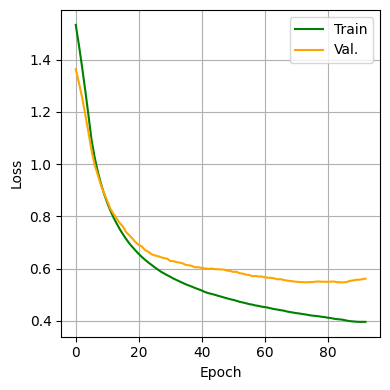

In [10]:
plot_learning_curves(history)

## 4) Prepare the Model for QAT

To prepare the model for QAT, it suffices to pass it to the PliNIO optimization method constructor (`MPS` in this example). The constructor internally implements the necessary conversion steps, adding "fake-quantization" operations to all Conv. and Linear layers. 

The constructor takes three main parameters:
- The previously created `nn.Module` of the "seed" DNN (better if already pre-trained)
- The shape of a single input sample (needed for internal graph analysis passes with `torch.fx`).
- A `qinfo` dictionary containing quantization configurations (type of quantizer, bit-width, optional arguments, etc, for each weight or activation tensor of the network).

Since defining `qinfo` from scratch could be annoying, we provide a utility function to generate a sane default, given only the desired weights and activations bit-widths to use. In this case, let's use 8-bit for both weights and activations. 

In [11]:
# get the default qinfo dictionary, specifying 8-bit as the only precision for both weights and activations
qinfo = get_default_qinfo((8,), (8,))

The `qinfo` dictionary has two default keys:
- `input_default` specifies the default quantizer for all input tensors.
- `layer_default` specifies the default quantizer for all weights and activations tensors of supported layers (currently Linear and Conv).

You can override these settings for each specific layer (or input) of your DNN by adding keys with the corresponding torch name.

In [12]:
print(qinfo.keys())

dict_keys(['layer_default', 'input_default'])


You may want to customize the quantizer for input tensors, depending on the nature of your training data. For example, as we have normalized CIFAR-10 images roughly to the $[-1,1]$ range with `transforms.Normalize` at the beginning of this notebook, we probably want our input quantizer to map the entirety of that range to the available integer values ($[-128:127]$ for 8-bit). To do so, we simply have to overwrite the dictionary entries corresponding to the `input_default` key. Namely:
- We set the input quantizer to `PACTActSigned`, a signed version of [PACT](https://arxiv.org/abs/1805.06085) with two trainable thresholds
- We initialize such two thresholds (called `init_clip_val_inf/sup` in PLiNIO's implementation) to -1 and +1 respectively


In [13]:
qinfo['input_default']['quantizer'] = PACTActSigned
qinfo['input_default']['kwargs'] = {'init_clip_val_inf': -1, 'init_clip_val_sup': +1}

We are now ready to call the `MPS` constructor:

In [ ]:
mps_model = MPS(copy.deepcopy(model), input_shape=input_shape, qinfo=qinfo)
mps_model = mps_model.to(device)

**NOTE**: as most other PLiNIO methods, `MPS` supports passing a **cost model** to the constructor, to specify non-functional optimization metric(s), e.g., model size, latency, energy, etc. However, since this example refers to a single-precision QAT (so both the network architecture and the precision are fixed), PLiNIO has *no freedom to optimize cost*, and the cost model is irrelevant.

In other words, after exporting the model and compiling it for edge inference, its size will be reduced by approximately 4x moving from float32 to int8, and latency will also most probably improve thanks to the usage of integer arithmetics. However, PLiNIO has no way to *alter the cost vs accuracy trade-off at training time* since the only available option is 8-bit quantization. 

Therefore, in this case, we can omit the cost model from the constructor.

### Evaluating the Converted Model

The model generated by the MPS constructor has fake-quantization operations to simulate `int8` precision. Furthermore, other optimizations are performed during the conversion, such as folding Batch Normalization layers with Convolutions or Linear layers. Overall, the result of the conversion is similar to what we would get with a (very basic) Post-Training Quantization (PTQ). Let's check how this model performs on our test data:

In [15]:
criterion = nn.CrossEntropyLoss()
test_metrics = evaluate(mps_model, criterion, test_loader, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Evaluation: 100%|██████████| 313/313 [00:03<00:00, 101.04it/s, accuracy=73.2, loss=0.78]

Test Loss: 0.7803315492674184, Test Acc: 73.15999865531921


As you can see, the performance drops significantly. Note that this is due to PLiNIO's MPS initialization currently not being particularly smart (e.g., all activation quantizers' initial ranges are set to the same default value, rather than being tuned to each tensor's distribution). However, QAT can usually recover this drop in a few epochs. Let's try it!

## 5) Running the Optimization

We are now ready to run QAT loop. Note that, if we wanted to actually *select* the bitwidth using MPS, we would have to implement something more similar to the `prune()` function in [this](https://github.com/eml-eda/plinio/blob/main/examples/channel_pruning_pit.ipynb) notebook (which exemplifies the PIT channel-pruning method). However, we're keeping a fixed precision, as discussed above. So, in this case, we can *entirely reuse* the `train()` function defined above, just passing the `mps_model` to it:

In [16]:
checkpoint_path = SAVE_DIR / "qat_best.pt"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mps_model.parameters(), lr=TRAINING_CONFIG['qat_lr'], weight_decay=TRAINING_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAINING_CONFIG['qat_epochs'])

history = train(checkpoint_path, TRAINING_CONFIG['qat_patience'], TRAINING_CONFIG['qat_epochs'], mps_model, criterion, optimizer, scheduler,
      train_loader, val_loader, device)

Evaluation: 100%|██████████| 313/313 [00:03<00:00, 89.10it/s, accuracy=78.5, loss=0.632]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 87.98it/s, accuracy=80.2, loss=0.574]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 89.13it/s, accuracy=81.2, loss=0.559]


Saved new best model.


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 89.05it/s, accuracy=81.3, loss=0.562]

Early stopping triggered after 16 epochs.


The QAT should terminate after few epochs.

### Evaluating the Fake-quantized Model

Let's check the test accuracy of the fake-quantized DNN after QAT:

In [17]:
mps_model.load_state_dict(torch.load(checkpoint_path))
mps_model.eval()

test_metrics = evaluate(mps_model, criterion, test_loader, device)
print(f'Exported Model Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Evaluation: 100%|██████████| 313/313 [00:03<00:00, 100.89it/s, accuracy=81.2, loss=0.55]

Exported Model Test Loss: 0.549550117347568, Test Acc: 81.22000098228455


The model should have now recovered the same validation accuracy of the float version.

## 6) Final Model Export

We can now call the `.export()` method of the PLiNIO MPS model. For other PLiNIO methods (SuperNet, PIT, etc) `.export()` returns a vanilla Torch model. However, in the case of MPS, we need to preserve quantization information, and the corresponding parameters. Therefore, exporting the model causes each quantized layer to be replaced with an instance of a custom quantized class (for instance, `nn.Conv2D` becomes `QuantConv2D`). These layers function analogously to the torch equivalents, but also store the quantization parameters (e.g. min/max values for each weight tensor), and use them to simulate the effect of quantization during inference.

In [18]:
quant_model = mps_model.export()
quant_model = quant_model.to(device)

Let's look at the exported model using `torchinfo`:

In [19]:
print(summary(quant_model, (1,) + input_shape, depth=5))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 10]                   --
├─QuantIdentity: 1-1                     [1, 3, 32, 32]            2
├─QuantConv2d: 1-2                       --                        (recursive)
│    └─PACTActSigned: 2-1                [1, 3, 32, 32]            2
├─QuantConv2d: 1-3                       [1, 16, 32, 32]           451
│    └─MinMaxWeight: 2-2                 [16, 3, 3, 3]             --
│    └─QuantizerBias: 2-3                [16]                      --
├─Module: 1-12                           --                        (recursive)
│    └─Module: 2-12                      --                        (recursive)
│    │    └─QuantConv2d: 3-5             --                        (recursive)
│    │    │    └─PACTAct: 4-1            [1, 16, 32, 32]           1
├─ReLU: 1-5                              [1, 16, 32, 32]           --
├─Module: 1-12                           --        

The printout shows the `Quant*` modules with their internal quantizers (`MinMaxWeight`,`QuantizerBias` and  `PACTAct` for weights, biases and activations respectively). Note that some layers do not have all quantizers as internal modules as PLiNIO automatically identifies *sharing constraints* (e.g., layers that must have the same output quantizer because their respective outputs are summed together).

### Export to ONNX for AI Compilation (Optional)

PLiNIO also supports exporting a quantized model to [ONNX](https://onnx.ai/) format, which is often used by AI compilers, especially for embedded/edge devices, for generating low-level code for the target. While the generated file follows the ONNX standard, tested compatibility with AI compilers is currently limited to [MATCH](https://arxiv.org/abs/2410.08855) (suggested) and [DORY](https://arxiv.org/abs/2008.07127) (deprecated). To generate a full-integer ONNX, we need two final steps:

- Integerization, which converts the model from fake-quantized to true-integer (i.e., all parameters, including scale factors for quantizers, are rounded to integers at the target precision.
- Backend exporting.

The following cell integerizes the model:

In [20]:
# convert the model to full-integer, compiler-compliant format
full_int_model = integerize_arch(copy.deepcopy(quant_model).cpu(), Backend.ONNX, backend_kwargs={'shift_pos': 16, 'scale_bit': 24, "dequantize_output": True})
#full_int_model = full_int_model.to(device)

Evaluate the full integer model to verify the final accuracy (a small drop is inevitable):

In [21]:
# test_metrics = evaluate(full_int_model, criterion, test_loader, device)
test_metrics = evaluate(full_int_model, criterion, test_loader, 'cpu')
print(f'Full Integer Model Test Acc: {test_metrics["acc"]}')

Evaluation: 100%|██████████| 313/313 [00:01<00:00, 161.74it/s, accuracy=81.4, loss=0.572]

Full Integer Model Test Acc: 81.41000270843506


Lastly, let's generate the output ONNX and save it to the DATA_DIR folder. You can open the `.onnx` file with a tool like [Netron](https://netron.app/) to verify its correctness.

In [22]:
exporter = ONNXExporter()
exporter.export(full_int_model, (1,) + input_shape, DATA_DIR)